# Object Detection API Installation

Follow the bellow for object detection: 

https://github.com/tensorflow/models/tree/master/research/object_detection

In [25]:
!pip install -U --pre tensorflow=="2.*"

Requirement already up-to-date: tensorflow==2.* in /usr/local/lib/python3.7/dist-packages (2.5.0rc1)


In [26]:
import tensorflow as tf
print("GPU Available: ", tf.config.list_physical_devices('GPU'))

print("Tensorflow Version: ", tf.__version__)

GPU Available:  []
Tensorflow Version:  2.5.0-rc1


In [27]:
!pip install pycocotools

In [47]:
import os
import pathlib


if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models

In [55]:
! git clone https://github.com/asyml/texar.git
! git clone https://github.com/tensorflow/models

fatal: destination path 'texar' already exists and is not an empty directory.
fatal: destination path 'models' already exists and is not an empty directory.


In [59]:
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.

following new git info 

```
! git clone https://github.com/tensorflow/models.git
# From the root of the git repository
docker build -f research/object_detection/dockerfiles/tf2/Dockerfile -t od .
docker run -it od
cd models/research
# Compile protos.
protoc object_detection/protos/*.proto --python_out=.
# Install TensorFlow Object Detection API.
cp object_detection/packages/tf2/setup.py .
python -m pip install --use-feature=2020-resolver 
# Test the installation.
python object_detection/builders/model_builder_tf2_test.py
```




In [60]:
%%bash 
cd models/research
pip install .

ERROR: Directory '.' is not installable. Neither 'setup.py' nor 'pyproject.toml' found.


In [24]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
from IPython.display import display

In [63]:
pip install tensorflow-object-detection-api

     |████████████████████████████████| 583kB 7.8MB/s 
     |████████████████████████████████| 61kB 6.7MB/s 
     |████████████████████████████████| 51kB 6.1MB/s 
     |████████████████████████████████| 3.2MB 15.1MB/s 
  Created wheel for tensorflow-object-detection-api: filename=tensorflow_object_detection_api-0.1.1-cp37-none-any.whl size=844515 sha256=1f1cc8bd25fa269e207d067ecfb84f61af54400851d9c84ada87e321a6dc0f2b
  Stored in directory: /root/.cache/pip/wheels/4a/54/d0/cfca11930c4b2025d40dede77059094070a67cc3e7bd3b285f
Successfully built tensorflow-object-detection-api


In [64]:
from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

In [66]:
# patch tf1 into `utils.ops`
utils_ops.tf = tf.compat.v1

# Patch the location of gfile
tf.gfile = tf.io.gfile

In [67]:
def load_model(model_name):
  base_url = 'http://download.tensorflow.org/models/object_detection/'
  model_file = model_name + '.tar.gz'
  model_dir = tf.keras.utils.get_file(
    fname=model_name, 
    origin=base_url + model_file,
    untar=True)

  model_dir = pathlib.Path(model_dir)/"saved_model"

  model = tf.saved_model.load(str(model_dir))
  model = model.signatures['serving_default']

  return model

In [68]:
# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = 'models/research/object_detection/data/mscoco_label_map.pbtxt'
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

In [69]:
# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
PATH_TO_TEST_IMAGES_DIR = pathlib.Path('models/research/object_detection/test_images')
TEST_IMAGE_PATHS = sorted(list(PATH_TO_TEST_IMAGES_DIR.glob("*.jpg")))
TEST_IMAGE_PATHS

[PosixPath('models/research/object_detection/test_images/image1.jpg'),
 PosixPath('models/research/object_detection/test_images/image2.jpg'),
 PosixPath('models/research/object_detection/test_images/image3.jpg')]

In [70]:
model_name = 'faster_rcnn_resnet101_coco_2018_01_28'
detection_model = load_model(model_name)

593453056/593445323 [==============================] - 5s 0us/step
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [71]:
print(detection_model.inputs)

[<tf.Tensor 'image_tensor:0' shape=(None, None, None, 3) dtype=uint8>]


In [72]:
detection_model.output_dtypes

{'detection_boxes': tf.float32,
 'detection_classes': tf.float32,
 'detection_scores': tf.float32,
 'num_detections': tf.float32}

In [73]:
detection_model.output_shapes

{'detection_boxes': TensorShape([None, 100, 4]),
 'detection_classes': TensorShape([None, 100]),
 'detection_scores': TensorShape([None, 100]),
 'num_detections': TensorShape([None])}

In [75]:
def run_inference_for_single_image(model, image):
  image = np.asarray(image)
  # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
  input_tensor = tf.convert_to_tensor(image)
  # The model expects a batch of images, so add an axis with `tf.newaxis`.
  input_tensor = input_tensor[tf.newaxis,...]

  # Run inference
  output_dict = model(input_tensor)

  # All outputs are batches tensors.
  # Convert to numpy arrays, and take index [0] to remove the batch dimension.
  # We're only interested in the first num_detections.
  num_detections = int(output_dict.pop('num_detections'))
  output_dict = {key:value[0, :num_detections].numpy() 
                 for key,value in output_dict.items()}
  output_dict['num_detections'] = num_detections

  # detection_classes should be ints.
  output_dict['detection_classes'] = output_dict['detection_classes'].astype(np.int64)
   
  # Handle models with masks:
  if 'detection_masks' in output_dict:
    # Reframe the the bbox mask to the image size.
    detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
              output_dict['detection_masks'], output_dict['detection_boxes'],
               image.shape[0], image.shape[1])      
    detection_masks_reframed = tf.cast(detection_masks_reframed > 0.5,
                                       tf.uint8)
    output_dict['detection_masks_reframed'] = detection_masks_reframed.numpy()
    
  return output_dict

In [76]:
def show_inference(model, image_path):
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = np.array(Image.open(image_path))
  # Actual detection.
  output_dict = run_inference_for_single_image(model, image_np)
  # Visualization of the results of a detection.
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks_reframed', None),
      use_normalized_coordinates=True,
      line_thickness=8)

  display(Image.fromarray(image_np))

In [77]:
scores = {}

In [78]:
#for image_path in TEST_IMAGE_PATHS:
  #show_inference(detection_model, image_path)

In [79]:
!wget https://thephiladelphiacitizen.org/wp-content/uploads/2019/09/parking-in-philadelphia.jpg -O people.jpg

--2021-04-14 05:59:16--  https://thephiladelphiacitizen.org/wp-content/uploads/2019/09/parking-in-philadelphia.jpg
Resolving thephiladelphiacitizen.org (thephiladelphiacitizen.org)... 104.21.19.173, 172.67.187.4, 2606:4700:3035::6815:13ad, ...
Connecting to thephiladelphiacitizen.org (thephiladelphiacitizen.org)|104.21.19.173|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 343063 (335K) [image/jpeg]
Saving to: ‘people.jpg’

people.jpg          100%[===================>] 335.02K  --.-KB/s    in 0.09s   

2021-04-14 05:59:16 (3.77 MB/s) - ‘people.jpg’ saved [343063/343063]



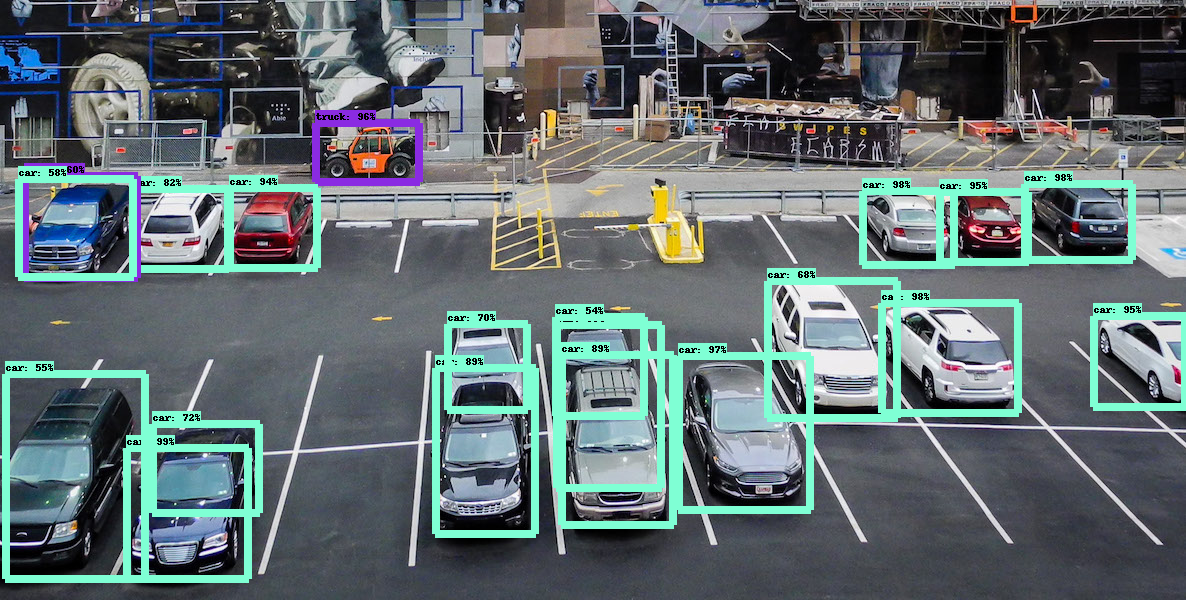

In [80]:
show_inference(detection_model, './people.jpg')